In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from scipy.special import comb
import math

In [5]:
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
             error**k *
             (1 - error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier = 11, error = 0.25)

0.03432750701904297

In [7]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier = 11, error = error) for error in error_range]

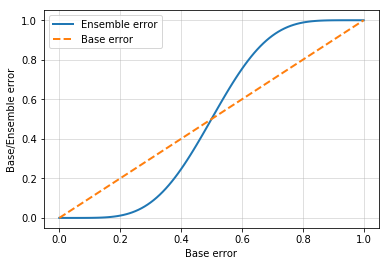

In [8]:
plt.plot(error_range, ens_errors, label = "Ensemble error", linewidth = 2)
plt.plot(error_range, error_range, linestyle = "--", label = "Base error", linewidth = 2)
plt.xlabel("Base error")
plt.ylabel("Base/Ensemble error")
plt.legend(loc = "upper left")
plt.grid(alpha = 0.5)
plt.show()

In [9]:
np.argmax(np.bincount([0,0,1], weights = [0.2, 0.2, 0.6]))

1

In [10]:
np.bincount([0,0,1], weights = [0.2, 0.2, 0.6])

array([0.4, 0.6])

In [12]:
list(enumerate(np.bincount([0,0,1], weights = [0.2, 0.2, 0.6])))

[(0, 0.4), (1, 0.6)]

In [13]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis = 0, weights = [0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [14]:
np.argmax(p)

0

In [15]:
%run -i majovote.py

<Figure size 432x288 with 0 Axes>

In [17]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [18]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1, stratify = y)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [23]:
clf1 = LogisticRegression(penalty = "l2", C = 0.001, random_state = 1, solver = "lbfgs")
clf2 = DecisionTreeClassifier(max_depth = 1, criterion = "entropy", random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = "minkowski")
pipe1 = Pipeline([["sc", StandardScaler()],
                  ["clf", clf1]])
pipe3 = Pipeline([["sc", StandardScaler()], 
                  ["clf", clf3]])
clf_labels = ["Logistic regression", "Decision tree", "KNN"]
print("10-fold cross validation:\n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train, 
                             cv = 10,
                             scoring = "roc_auc")
    print("ROC AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [24]:
mv_clf = MajorityVoteClassifier(classifiers = [pipe1, clf2, pipe3])
clf_labels += ["Majority voting"]
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = "roc_auc")
    
    print("ROC AUC: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


In [27]:
list(zip(all_clf, clf_labels))

[(Pipeline(memory=None,
       steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
            tol=0.0001, verbose=0, warm_start=False)]]),
  'Logistic regression'),
 (DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=0,
              splitter='best'), 'Decision tree'),
 (Pipeline(memory=None,
       steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_param

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

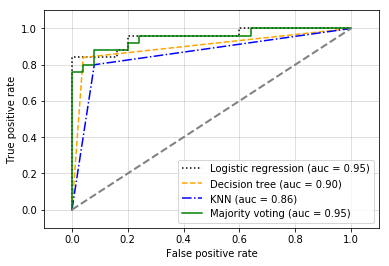

In [29]:
colors = ["black", "orange", "blue", "green"]
linestyles = [":", "--", "-.", "-"]
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_pred)
    roc_auc = auc(x = fpr, y = tpr)
    plt.plot(fpr, tpr, color = clr, linestyle = ls, label = "%s (auc = %.2f)" % (label, roc_auc))
plt.legend(loc = "lower right")
plt.plot([0,1], [0,1], linestyle = "--", color = "gray", linewidth = 2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha = 0.5)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [30]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

In [31]:
from itertools import product

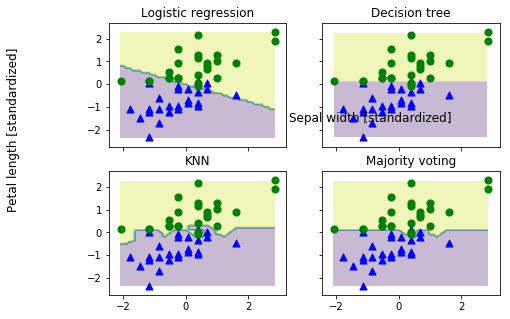

In [32]:
x_min = X_train_std[:, 0].min()
x_max = X_train_std[:, 0].max()
y_min = X_train_std[:, 1].min()
y_max = X_train_std[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 2, ncols = 2, sharex = "col", sharey = "row", figsize = (7, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                                  X_train_std[y_train == 0, 1],
                                  c = "blue", marker = "^", s = 50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                                  X_train_std[y_train == 1, 1],
                                  c = "green", marker = "o", s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, 5.,
         s = "Sepal width [standardized]", va = "center", fontsize = 12)
plt.text(-12.5, 4.5,
         s = "Petal length [standardized]", va = "center", fontsize = 12, rotation = 90)
plt.show()

In [33]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=1, solver='lbfgs',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
params = {"decisiontreeclassifier__max_depth": [1, 2],
          "pipeline-1__clf__C": [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator = mv_clf,
                    param_grid = params,
                    cv = 10, scoring = "roc_auc")
grid.fit(X_train, y_train)

/Users/mito/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
for r, _ in enumerate(grid.cv_results_["mean_test_score"]):
    print("%.3f +/- %.2f %r" 
          % (grid.cv_results_["mean_test_score"][r],
             grid.cv_results_["std_test_score"][r] / 2.0,
             grid.cv_results_["params"][r]))

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [37]:
print("Best parameters: %s" % grid.best_params_)
print("Accuracy: %.2f" % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


In [40]:
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header = None)
df_wine.columns = ["Class label", "Alcohol", "Malic acid", "Ash",
                   "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
                   "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue",
                   "OD280/OD315 of diluted wines", "Proline"]

In [41]:
df_wine = df_wine[df_wine["Class label"] != 1]
y = df_wine["Class label"].values
X = df_wine[["Alcohol", "OD280/OD315 of diluted wines"]].values

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [43]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [44]:
from sklearn.ensemble import BaggingClassifier

In [45]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = None, random_state = 1)
bag = BaggingClassifier(base_estimator = tree,
                        n_estimators = 500,
                        max_samples = 1.0,
                        max_features = 1.0,
                        bootstrap = True,
                        bootstrap_features = False,
                        n_jobs = 1,
                        random_state = 1)

In [46]:
from sklearn.metrics import accuracy_score

In [47]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print("Decision tree train/test accuracies: %.3f/%.3f" % (tree_train, tree_test))

Decision tree train/test accuracies: 1.000/0.833


In [48]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print("Bagging train/test accuracies %.3f/%.3f" % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


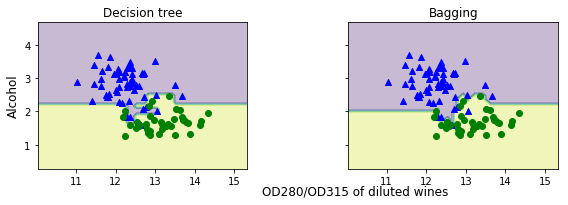

In [50]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2, sharex = "col", sharey = "row", figsize = (8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ["Decision tree", "Bagging"]):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c = "blue", marker = "^")
    axarr[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c = "green", marker = "o")
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel("Alcohol", fontsize = 12)
plt.text(10.2, -0.5, s = "OD280/OD315 of diluted wines", ha = "center", fontsize = 12)
plt.tight_layout()
plt.show()

In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
tree = DecisionTreeClassifier(criterion = "entropy", max_depth = 1, random_state = 1)
ada = AdaBoostClassifier(base_estimator = tree, n_estimators = 500, learning_rate = 0.1, random_state = 1)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print("Decision tree train/test accuracies %.3f/%.3f" % (tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


In [54]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print("AdaBoost train/test accuracies %.3f/%.3f" % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


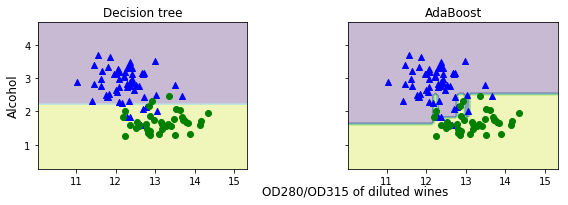

In [55]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows = 1, ncols = 2, sharex = "col", sharey = "row", figsize = (8, 3))
for idx, clf, tt in zip([0, 1], [tree, ada], ["Decision tree", "AdaBoost"]):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c = "blue", marker = "^")
    axarr[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c = "green", marker = "o")
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel("Alcohol", fontsize = 12)
plt.text(10.2, -0.5, s = "OD280/OD315 of diluted wines", ha = "center", fontsize = 12)
plt.tight_layout()
plt.show()